
# Predict rain based on other weather variables

This notebook will use time lags to train a machine learning model for predicting temprature. 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import glob
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
%%time
data_dir = '/datasets/NOAA_SST/'  # use '\\' on windows, e.g. 'C:\\user\\datasets\\NOOAA_SST'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

26.046356439590454
CPU times: user 13.7 s, sys: 12.4 s, total: 26.1 s
Wall time: 26 s


In [4]:
stations.head()

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
0,007018,99999,WXPOD 7018,None,None,None,0.00,0.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,None,None,0.00,0.000,+7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,None,None,0.00,0.000,+7070.0,20140923,20150926
3,008268,99999,WXPOD8278,AF,None,None,32.95,65.567,+1156.7,20100519,20120323
4,008307,99999,WXPOD 8318,AF,None,None,0.00,0.000,+8318.0,20100421,20100421


In [5]:
data.head()

,stn,temp,slp,wdsp,mxpsd,max,min,prcp
Datetime,,,,,,,,
2008-08-22,619970,41.7,1032.1,7.2,14.0,46.6,37.8,0.00
2008-09-28,714170,54.9,1023.8,9.1,15.0,70.3,51.4,0.06
2008-02-14,041560,35.6,1032.8,28.5,38.9,36.5,34.5,0.00
2008-02-25,041560,4.5,997.1,4.3,7.0,10.4,-1.1,0.00
2008-10-06,041650,43.3,998.8,24.3,30.9,44.6,40.3,0.00


In [6]:
# # SELECT RANDOM STATION # #
np.random.seed(30)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

# # ideally we should check < len(np.unique(data.index)), but many are shorter
while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
    else:
        rand_stat = rs[randint(len(rs))] # get a new station

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station

features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.drop(columns='max')
features = features.drop(columns='min')
features = features.sort_index()
select_station.head() # see where it is

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
24140,711320,99999,STONY RAPIDS ARPT,CA,None,CYSF,59.25,-105.833,+0250.0,19860725,20190401


In [7]:
features.head()

,temp,slp,wdsp,mxpsd,prcp
Datetime,,,,,
2008-01-01,-8.3,1035.4,1.4,5.1,0.01
2008-01-02,-6.9,1022.2,4.2,9.9,0.00
2008-01-03,9.2,996.6,2.0,9.9,0.04
2008-01-04,7.9,998.0,3.4,9.9,0.00
2008-01-05,6.8,995.4,9.7,12.0,0.13


### Time-shift the data

In [8]:
columns = features.columns 
for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

3991 samples, 20 features.


,temp,slp,wdsp,mxpsd,prcp,temp_lag1,temp_lag2,temp_lag3,slp_lag1,slp_lag2,slp_lag3,wdsp_lag1,wdsp_lag2,wdsp_lag3,mxpsd_lag1,mxpsd_lag2,mxpsd_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,
2008-01-04,7.9,998.0,3.4,9.9,0.00,9.2,-6.9,-8.3,996.6,1022.2,1035.4,2.0,4.2,1.4,9.9,9.9,5.1,0.04,0.00,0.01
2008-01-05,6.8,995.4,9.7,12.0,0.13,7.9,9.2,-6.9,998.0,996.6,1022.2,3.4,2.0,4.2,9.9,9.9,9.9,0.00,0.04,0.00
2008-01-06,4.0,993.5,8.5,13.0,0.09,6.8,7.9,9.2,995.4,998.0,996.6,9.7,3.4,2.0,12.0,9.9,9.9,0.13,0.00,0.04
2008-01-07,4.7,1001.9,0.6,2.9,0.05,4.0,6.8,7.9,993.5,995.4,998.0,8.5,9.7,3.4,13.0,12.0,9.9,0.09,0.13,0.00
2008-01-08,-4.2,1011.6,0.3,2.9,0.06,4.7,4.0,6.8,1001.9,993.5,995.4,0.6,8.5,9.7,2.9,13.0,12.0,0.05,0.09,0.13


In [9]:
features["prcp"].describe()

count    3991.000000
mean        0.030574
std         0.105823
min         0.000000
25%         0.000000
50%         0.000000
75%         0.010000
max         1.890000
Name: prcp, dtype: float64

In [12]:
import seaborn as sns

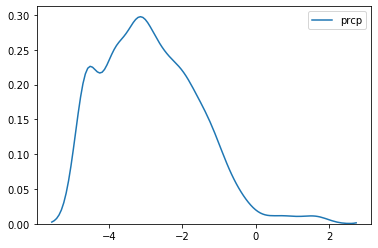

In [26]:
sns.kdeplot(np.log(features['prcp']))

In [10]:
# Show the position of the station

fig = plt.figure(figsize=(18.5, 10.5))
m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
            llcrnrlon=-180,urcrnrlon=180, resolution='l')
m.drawmapboundary(fill_color='xkcd:lightblue')
m.fillcontinents(color='xkcd:green',lake_color='xkcd:lightblue')
m.drawmeridians(np.arange(-180.,180.,30.),labels=[True,False,False,True])
m.drawparallels(np.arange(-90.,90,30.),labels=[False,True,True,False])
lon = select_station['lon'].tolist()
lat = select_station['lat'].tolist()
m.plot(lon, lat,'r+') 
plt.show()

NameError: name 'Basemap' is not defined

<Figure size 1332x756 with 0 Axes>

### Create train/val/test

In [11]:
ylabel = features['temp'] # use today's temperature as the label
features = features.drop(columns='temp') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

# Split remaining 80% into training-validation sets (of original data)
x_train, x_val, y_train, y_val, train_ind, val_ind = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], indices, test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [16]:
train_ind[:10]


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Hyperparameter Tuning using Randomized Search to select good hyperparameter values for Randomized 

In [ ]:
ylabel = features['temp'] # use today's temperature as the label
features = features.drop(columns='temp') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)

x_train, y_train = features.iloc[0:ntrain, :], y_label[0:ntrain]
#x_train, x_val, y_train, y_val, train_ind, val_ind = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], indices, test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)

In [ ]:
from sklearn.model_selection import RandomizedSearch

In [ ]:
reg = RandomForestRegressor(random_state = 10)

In [ ]:
n_estimators_values = [50, 100, 300, 800, 1500, 2000]
max_features_values = ["log2", "sqrt", "auto"]
max_depth_values = [5, 7, 10, 15, 20, 50, 80, 150, None]
min_samples_split_values = [2, 3, 5, 7, 10]
min_samples_leaf_values = []
bootstrap_values = [True, False]
criterion_values = ["mse", "mae"]
max_leaf_nodes_values = []


In [ ]:
search_grid = {
    'n_estimators' : n_estimators_values,
    'max_features' : max_features_values,
    'max_depth' : max_depth_values,
    'min_samples_split' : min_samples_split_values,
    'min_samples_leaf' : min_samples_leaf_values,
    'bootstrap' : bootstrap_values,
    'criterion' : criterion_values,
    'max_leaf_nodes' : max_leaf_nodes_values
}

In [ ]:
rf_cross_validator = RandomizedSearchCV(estimator = reg, param_distributions = search_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 60, n_jobs = -1)

In [ ]:
rf_cross_validator.fit(x_train, y_train)

Best hyperparameters

In [ ]:
best_params = rf_cross_validator.best_params_

In [ ]:
regr = RandomForestRegressor()

In [ ]:
x_train, x_val, y_train, y_val, train_ind, val_ind = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], indices, test_size=0.2, random_state=1)

# Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### Predict with Random Forest

In [12]:
# # Create, train, and predict random forest here, where regr is the regressor and y is the predicted test results with random forest # #

clf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state = 10)
clf.fit(x_train, y_train)

# # Also predict on the training and validation data
y_train_pred = clf.predict(x_train)
y_val_pred = clf.predict(x_val)

y = clf.predict(x_test)

In [13]:
regr = clf

In [14]:
train_pred_df = pd.Series(data = y_train_pred, index = features.iloc[train_ind].index)
val_pred_df = pd.Series(data = y_val_pred, index = features.iloc[val_ind].index)

In [18]:
train_pred_df = train_pred_df.append(val_pred_df)

In [19]:
len(train_pred_df)

3192

In [22]:
train_pred_df = train_pred_df.sort_index()

In [23]:
train_pred_df

Datetime
2008-01-04     5.811117
2008-01-05     6.764583
2008-01-06     4.649288
2008-01-07     3.699892
2008-01-08    -0.023680
                ...    
2016-10-07    34.803808
2016-10-08    29.789635
2016-10-09    33.515209
2016-10-10    32.794757
2016-10-11    32.929050
Length: 3192, dtype: float64

### Plot random forest

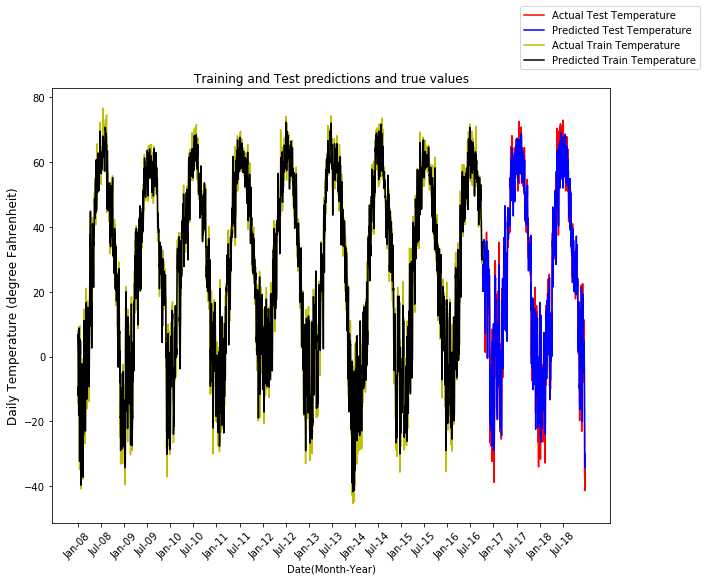

In [43]:
# plot predictions
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Temperature") # plot actual temperature
ax.plot(features.iloc[ntrain:].index, y, 'b', label="Predicted Test Temperature") # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
ax.plot(features.iloc[0:ntrain].index, ylabel[0:ntrain], 'y', label="Actual Train Temperature")
ax.plot(features.iloc[0:ntrain].index, train_pred_df, 'k', label="Predicted Train Temperature")

#plt.plot(features.iloc[val_ind].index, y_val, 'm', label="Actual Val Temperature")
#plt.plot(features.iloc[val_ind].index, y_val_pred, 'c', label="Predicted Val Temperature")

# # INCREASE X TICK SPACING, UPDATE LEGEND # #
ax.set_xticks(features.iloc[:].index[::182]) # set xticks to monthly
ax.set_xticklabels(ax.get_xticks(), rotation=45)
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
ax.set_title('Training and Test predictions and true values')
ax.set_ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
ax.set_xlabel('Date(Month-Year)')
lgd = ax.legend(bbox_to_anchor=(1, 1.2), loc='upper center')
fig.savefig("problem 1.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# # Plot the feature importances # #


In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
mean_squared_error(y_test, y)

46.220861705502315

In [29]:
mean_squared_error(ylabel[train_ind], y_train_pred)

9.536931429588996

In [1]:
mean_squared_error(ylabel[val_ind], y_val_pred)

NameError: name 'mean_squared_error' is not defined

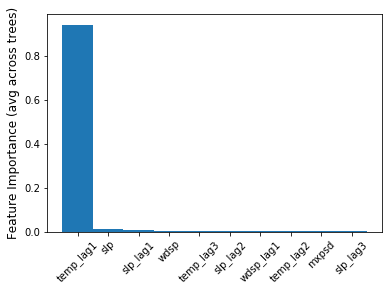

In [44]:
# # Plot the feature importances # #
nfeatures = 10
fi = regr.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# plot predictions
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Temperature") # plot actual temperature
plt.plot(features.iloc[ntrain:].index, y, 'b', label="Predicted Test Temperature") # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
#plt.subplot(2,2,2)
plt.plot(features.iloc[:ntrain].index, ylabel[:ntrain], 'c', label="Actual Train Temperature")
plt.plot(features.iloc[:ntrain].index, y_train_pred, 'm', label="Predicted Train Temperature")


# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.iloc[:].index[::182], rotation = 45) # set xticks to monthly
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.legend(['Test Label','Test Prediction','Train Label','Train Prediction'], fontsize=12, loc=1)
#plt.show()

# # Plot the feature importances # #
nfeatures = 10
fi = regr.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.subplot(2,2,4)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

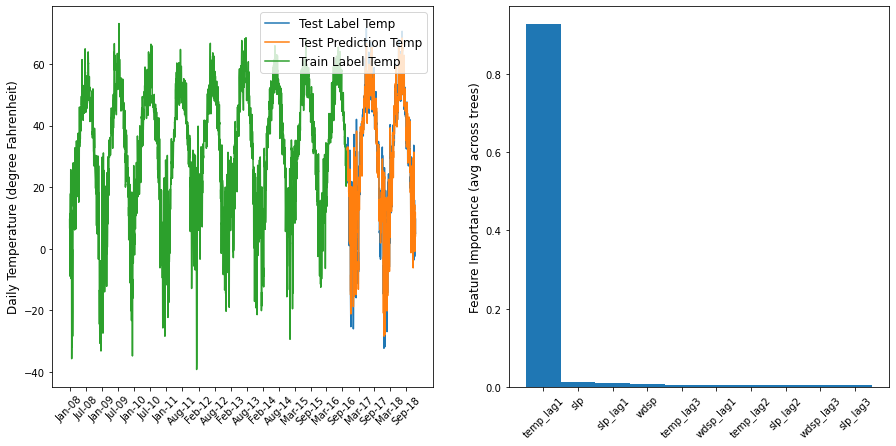

In [47]:
# plot predictions
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
plt.plot(features.iloc[ntrain:].index,y_test, 'r', label="Actual Test Temperature") # plot actual temperature
plt.plot(features.iloc[ntrain:].index, y, 'b', label="Predicted Test Temperature") # plot predicted temperature

# # PLOT THE PREDICTED TRAINING AND VALIDATION DATA HERE # #
plt.subplot(2,2,2)
plt.plot(features.iloc[:ntrain].index,ylabel[0:ntrain])
plt.plot(x_train.index, y_train_pred)

plt.subplot(2,2,3)
plt.plot(x_val.index, y_val_pred)


# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.iloc[:].index[::182], rotation = 45) # set xticks to monthly
myFmt = mdates.DateFormatter('%b-%y')
plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Temperature (degree Fahrenheit)', fontsize=12)
plt.legend(['Test Label','Test Prediction','Train Label','Train Prediction'], fontsize=12, loc=1)
#plt.show()

# # Plot the feature importances # #
nfeatures = 10
fi = regr.feature_importances_ # get feature importances
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

### Feature importance is the weighted impurity of a branch adjusted by its children nodes and normalized by the impurities of all branches. The Random Forest feature importances are averaged over all regression trees.

43.60456337443424